In [1]:
from IPython.display import Video

# Apprentissage par Renforcement 

#### Sommaire

- [I - Morpion](#morpion)
  * [I.1 - Moteur du jeu](#moteur-du-jeu)
  * [I.2 - MinMax](#minmax)
    + [I.2.a - Le principe](#le-principe)
    + [I.2.b - Exemple](#exemple)
    + [I.2.c - Résultats](#resultats)
    + [I.2.d - Optimisation](#optimisation)
    + [I.2.e - Conclusion](#conclusion)
  * [I.3 - Apprentissage par renforcement](#apprentissage-par-renforcement)
    + [I.3.a - Principe général](#principe-general)
    + [I.3.b - Implémentation du jeu](#implementation-du-jeu)
    + [I.3.c - Apprentissage](#apprentissage)
    + [I.3.d - Résultats](#resultats-2)
    + [I.3.e - Apprentissage Monte-Carlo](#apprentissage-monte-carlo)
    + [I.3.f - Resultats Monte-Carlo](#resultats-monte-carlo)
  * [I.4 - Conclusion](#conclusion-2)
- [II - Snake](#snake)
  * [II.0 - Modules, constantes et autre](#modules)
  * [II.1 - Moteur du jeu](#moteur-du-jeu-snake)
      + [II.1.a - Principe](#principe-snake)
      + [II.1.b - Environnement](#environnement-snake)
      + [II.1.c - Déplacements du joueur et score](#deplacement-du-joueur)
  * [II.2 - Apprentissage par renforcement](#apprentissage_par_renforcement_snake)
      + [II.2.a - Fonctions utiles](#fonctions_utiles)
      + [II.2.b - Apprentissage Mont-Carlo](#apprentissage-monte-carlo-snake)
      + [II.2.c - Apprentissage Temporal Difference](#temporal-difference)
  * [II.3 - Meilleur vecteur caractéristique](#meilleur-vecteur)  


Le but de ce projet informatique est d'implémenter différentes techniques d'apprentissage par renforcement de plus en plus complexes sur différents jeux. Pour le coté thérorique, j'ai suivi le cours suivant : [cours](https://github.com/dennybritz/reinforcement-learning). Il s'appuie sur le livre de Richard S. Sutton et Andrew G.Barto ([livre](http://incompleteideas.net/book/RLbook2018.pdf)) et le cours de David Silver sur l'apprentissage par renforcement ([vidéos](https://www.davidsilver.uk/teaching/)).

Le projet se décompose en deux parties qui diffèrent sur les jeux que j'essaye de résoudre. La première partie consiste à implémenter une méthode MinMax sur le jeu du morpion puis la variante Monte-Carlo de l'apprentissage par renforcement. La seconde partie s'intéresse à un jeu plus complexe : Snake. Ici l'espace d'états et d'actions est trop grand pour avoir une fonction valeur exacte et donc cela me force à implémenter des algorithmes d'apprentissage avec une fonction valeur approximée.

Les explications en profondeur sont données au fur et à mesure du notebook : il est donc de grande taille, mais voici un résumé de mes résultats.

#### I - Morpion

L'algorithme de MinMax n'a pas posé de difficulté majeure et son implémentation donne un algorithme imbattable. Malheureusement la complexité de l'algorithme ([lien vers calcul](#complexity)) rend celui-ci inutilisable pour l'apprentissage des algorithmes qui suivent. La solution a été de précalculer toutes les situations possibles et de leur associer les meilleures stratégies pour réduire la complexité à une recherche dans un tableau.

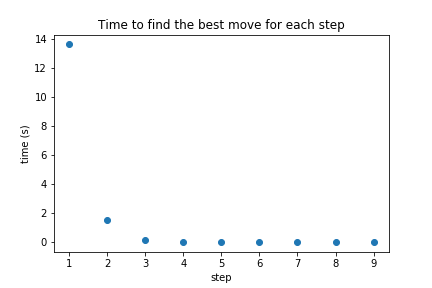 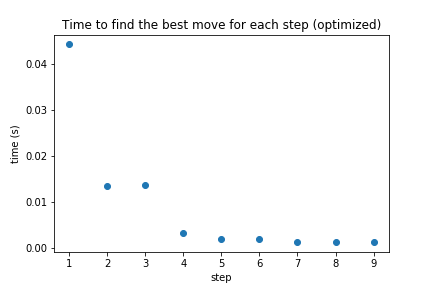

L'étape suivante était donc d'implémenter un algorithme d'apprentissage par renforcement. Dans un premier temps la mise à jour du tableau de valeur était trop lente ce qui rendait l'apprentissage trop long mais après avoir implémenter la méthode de Monte-Carlo ont réussi à avoir un programme qui est aussi fort que le MinMax

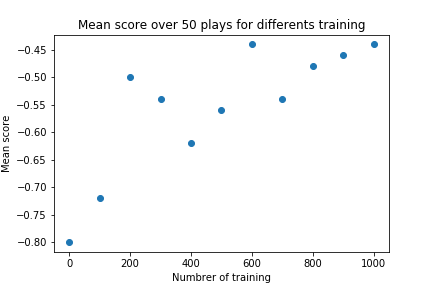 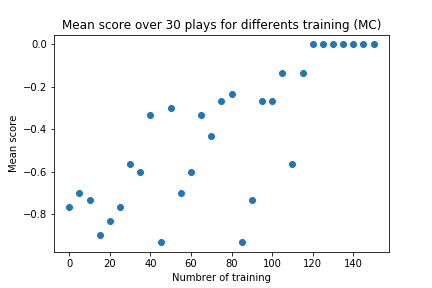

Pour conclure on obtient bien un programme efficace avec les méthodes d'apprentissage par renforcement mais elles sont plus lentes dans tous les cas que le MinMax. Mais fort de l'experience gagnée je passe à la prochaine partie : Snake.

(Lorsque dans le code il y a une ligne commentée `play_**********()` il ne faut pas hésiter à la décommenter pour jouer !)

#### II - Snake (WIP)

L'implémentation de Snake s'est faite dans un premier temps avec un modèle simplifié contenant un serpent de taille 1, un fruit et un seul obstacle. 
Cette fois-ci contrairement au Morpion le cadre d'apprentissage n'est pas toujours le même on ne peut pas simplement crée un grand tableau avec toutes les possibilités d'état.

**On passe donc par une fonction d'approximation**

Il existe plusieurs manières d'approximer cette fonction mais je suis parti avec l'idée de passer en premier par les idées les plus simples avant de les complexifier. J'ai donc approximé la situation par un vecteur de caractéristiques.

$$X = \begin{pmatrix} d_{joueur-fruit} \\ d_{joueur-obstacle} \end{pmatrix}$$

"Apprendre" revient donc à trouver le meilleur vecteur de pondération qui donnera la stratégie à suivre en fonction de $X$.

In [2]:
Video("data/snake_rand.mp4")

Après un passage de Monte-Carlo vers Temporal Difference à cause de la variance du premier qui empechait l'apprentissage de bien se dérouler on arrive à un résultat propéteur mais loin d'être parfait.

In [3]:
Video("data/snake_strat.mp4")

Je me suis donc dit qu'il fallait complexifier le vecteur de caractéristique pour mieux rendre compte de l'état du jeu. Voici donc le nouveau vecteur caractéristique et on voit que maintenant on est passé à une fonction de valeur de pair (état, action).

$$ X(S,a) = \begin{pmatrix} rapprochement\_fruit \\ rapprochement\_obstacle \\ d_{fruit} \\ d_{obstacle} \end{pmatrix} $$

Malheureusement les résultats ne sont pas plus prometteurs.

La prochaine piste est d'implémenté un réseau de neurone pour trouver la bonne fonction d'approximation.

#### Difficultés

La première partie ne m'a pas posé de grandes difficultés car les algorithmes utilisés sont très souvent implémenté sur le jeu morpion me donnant ainsi beaucoup de références.

La seconde partie n'avait rien a voir, je n'ai trouvé aucun projet comme le mien sur Internet (où l'on utilise pas une libraire de machine learning). J'ai donc passé beaucoup de temps non seulement à suivre le cours de github mais également (et même plus) à chercher les erreurs qui fausse le résultat lors des implémentations.

Le passage du théorique au cas réel n'est vraiment pas évident !

# I - Morpion <a id="morpion"></a>

Le but de cette partie est de produire un programme capable de jouer seul au moripion, soit contre un joueur, soit contre lui-même.

In [4]:
import numpy as np
import itertools
import sys
import matplotlib.pyplot as plt
import unittest

from time import time

## I.1 - Moteur du jeu <a id="moteur-du-jeu"></a>

Le jeu du morpion est composé d'une grille de neuf cases où deux joueurs s'affrontent pour essayer d'aligner trois symboles. ([Règles](https://fr.wikipedia.org/wiki/Morpion_(jeu)))

Ci-dessous, j'ai implémenté les règles de bases et l'affichage pour pouvoir jouer au morpion.

In [5]:
def num2pos(num):
    '''
    Transform the number of the block into the position in the 2D array
    '''
    
    return(int((num-1)/3),int((num-1)%3))

def play_move(board, player):
    ''' 
    Ask the player <player> where he wants to play 
    (verify that it's possible) and play the move
    '''
    
    print(f"{player} turn :")
    
    # position selection
    num = int(input("Where do you want to play (1-9): "))
    while board[num2pos(num)] != ' ':
        num = int(input("This case is not empty (1-9): "))
     
    move(board, player, num)

def move(board, player, block):
    '''
    Put the correct symbole <player> to the <block>
    (/!\ don't check if it's valid position)
    '''
    board[num2pos(block)] = player
    
def print_board(board):
    '''
    Print a nice board
    '''
    
    print('┌───┬───┬───┐')
    print('│ ' + str(board[(0,0)]) + ' │ ' + str(board[(0,1)]) \
                                          + ' │ ' + str(board[(0,2)]) + ' │')
    print('├───┼───┼───┤')
    print('│ ' + str(board[(1,0)]) + ' │ ' + str(board[(1,1)]) \
                                          + ' │ ' + str(board[(1,2)]) + ' │')
    print('├───┼───┼───┤')
    print('│ ' + str(board[(2,0)]) + ' │ ' + str(board[(2,1)]) \
                                          + ' │ ' + str(board[(2,2)]) + ' │')
    print('└───┴───┴───┘')

def state_board(board):
    '''
    Check the state of the board 
    
    Retruns :
        (<state>, <winner>)
        <state> : Done, Not Done, Draw
        <winner> : 'X', 'O', None
    '''
    # check for three identical symbols verticaly or horizontaly
    for i in range(3):
        if board[i,0] != ' ' and len(set(board[i,:])) == 1:
            return("Done", board[i,0])
        if board[0,i] != ' ' and len(set(board[:,i])) == 1: 
            return("Done", board[0,i])
    
    # check diagonaly
    if board[0,0] != ' ' and board[0,0] == board[1,1] == board[2,2]:
        return("Done", board[1,1])    
    if board[0,2] != ' ' and board[0,2] == board[1,1] == board[2,0]:
        return("Done", board[1,1])
    
    # check for ties
    if not(' ' in set(board.flatten())):
        return("Draw", None)

    # If nothing else the game continue
    return("Not Done", None)

In [6]:
def play_human_human():
    '''
    A game of Tic-tac-toe for 2 human players
    '''
    
    # Initalisation
    board = np.full((3,3), ' ')
    players = ['X', 'O']

    state = "Not Done"
    player = 0
    
    while state == "Not Done":
        print_board(board)
        
        play_move(board, players[player])
        state, winner = state_board(board)
        
        # Change player 
        player = (player + 1) % 2 
        
    print_board(board)
    
    if state == "Done":
        print(f"{winner} have won")
    else:
        print(state)
        print("It a draw")

In [7]:
class moripion_test(unittest.TestCase):
    '''
    Test case for the game moripion
    '''
    
    def test_win(self):
        '''
        Test if the program is capable of detecting a win.
        '''
        
        state1 = np.array([['X', 'O', 'X'],
                           [' ', ' ', ' '],
                           [' ', ' ', ' ']])
        state2 = np.array([['X', 'O', ' '],
                           [' ', 'O', ' '],
                           [' ', 'O', 'X']])
        state3 = np.array([['X', ' ', ' '],
                           [' ', 'X', ' '],
                           [' ', ' ', 'X']])
        state4 = np.array([['O', 'X', 'O'],
                           ['X', 'X', 'O'],
                           ['O', 'O', 'X']])
        
        
        self.assertEqual(state_board(state1), ('Not Done', None))
        self.assertEqual(state_board(state2), ('Done', 'O'))
        self.assertEqual(state_board(state3), ('Done', 'X'))
        self.assertEqual(state_board(state4), ('Draw', None)) 

In [8]:
#play_human_human()

## I.2 - MinMax <a id="minmax"></a>

Le premier algorithme que j'implémente est un algorithme MinMax. 
C'est un algorithme qui s'applique pour les jeux à deux joueurs à information complète et à somme nulle ce qui est le cas du morpion. 

C'est souvent le premier algorithme implémenté pour ce jeu car il n'est pas difficile.

### I.2.a - Le principe <a id="le-principe"></a>

Pour chaque coup de l'ordinateur on crée un arbre avec tous les coups possibles à partir de la situation qu'on lui donne.
A chaque niveau de l'arbre, c'est un joueur différent qui joue :
- la racine : l'ordinateur
- les noeuds juste en dessous : l'adversaire
- ...

Lorsqu'on arrive aux feuilles, on donne un score à la situation selon la règle suivante :
- Si c'est l'ordinateur qui gagne : 1
- Si c'est l'adversaire : -1
- Sinon : 0

On remonte ensuite les noeuds en fonction de la règle suivante :
- Si le noeud est celui de l'ordinateur on prend le max de ces descendants
- Sinon on prend le min de ces descendants

### I.2.b - Exemple <a id="exemple"></a>

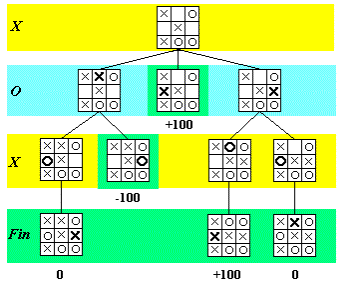


In [9]:
def min_max(board, player, player_init):
    '''
    Take a state of the board and using the MinMax algorithm 
    returns the best move
    '''
    players = ['X', 'O']
    
    state, winner = state_board(board)

    # final state
    if state == "Done":
        if winner == players[player_init]:
            return(1)
        else:
            return(-1)
    if state == "Draw":
        return(0)
    
    empty_cells = [num for num in range(1,10) if board[num2pos(num)] == ' ']
    results = []
    
    # Creats the tree
    for empty_cell in empty_cells:
        new_board = np.copy(board)
        move(new_board, players[player], empty_cell)
        
        result = [empty_cell, min_max(new_board, (player + 1)%2, player_init)]
        results.append(result)
    
    if player == player_init:  # If the player init is playing take the minimum score
        best = -float('inf')
        for result in results:
            if result[1] > best:
                best_move, best = result
    else:
        best = float('inf')
        for result in results:
            if result[1] < best:
                best_move, best = result
    return(best)

In [10]:
def best_play(board, player):
    '''
    Gives the best move for the player <player>
    '''
    players = ['X', 'O']
    
    possible_play = [num for num in range(1,10) if board[num2pos(num)] == ' ']
    results = []
    
    for play in possible_play:
        new_board = np.copy(board)
        move(new_board, players[player], play)
        results.append([play, min_max(new_board, (player + 1)%2, player)])

    best = -float('inf')
    for play in results:
        if play[1] > best:
            best_play, best = play
    return(best_play)

In [11]:
def play_human_min_max():
    '''
    A game of Tic-tac-toe for a human against the minmax algorithm
    '''
    
    # Initalisation
    board = np.full((3,3), ' ')
    players = ['X', 'O']

    state = "Not Done"
    player = 0
    AI = 1
    
    while state == "Not Done":
        
        # player turn
        print_board(board)
        play_move(board, players[player])
        state, winner = state_board(board)
       
        if state != "Not Done":
            break
            
         # IA turn
        move(board, players[AI], best_play(board, AI))
        state, winner = state_board(board)
        
    print_board(board)
    
    if state == "Done":
        print(f"{winner} have won")
    else:
        print("It a draw")

In [80]:
play_human_min_max()

┌───┬───┬───┐
│   │   │   │
├───┼───┼───┤
│   │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
X turn :
Where do you want to play (1-9): 2
┌───┬───┬───┐
│ O │ X │   │
├───┼───┼───┤
│   │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
X turn :
Where do you want to play (1-9): 5
┌───┬───┬───┐
│ O │ X │   │
├───┼───┼───┤
│   │ X │   │
├───┼───┼───┤
│   │ O │   │
└───┴───┴───┘
X turn :
Where do you want to play (1-9): 2
This case is not empty (1-9): 3
┌───┬───┬───┐
│ O │ X │ X │
├───┼───┼───┤
│   │ X │   │
├───┼───┼───┤
│ O │ O │   │
└───┴───┴───┘
X turn :
Where do you want to play (1-9): 6
┌───┬───┬───┐
│ O │ X │ X │
├───┼───┼───┤
│ O │ X │ X │
├───┼───┼───┤
│ O │ O │   │
└───┴───┴───┘
O have won


In [13]:
def play_min_max_min_max(verb=True):
    '''
    A game of Tic-tac-toe for the minmax against the minmax
    
    Returns the time for each steps
    '''
        
    board = np.full((3,3), ' ')
    players = ['X', 'O']

    state = "Not Done"
    player = 0
    
    time_steps = []
    
    while state == "Not Done":
        
        t1 = time()
        # AI_1 turn
        move(board, players[player], best_play(board, player))
        state, winner = state_board(board)
        t2 = time()
        
        time_steps += [t2-t1]
        
        # Change player 
        player = (player + 1) % 2
        
        if verb: 
            print_board(board)
            print('It took {:.2f}s to find the move'.format(time_steps[-1]))
       
        if state != "Not Done":
            break
        
    if verb:
        if state == "Done":
            print(f"{winner} have won")
        else:
            print("It a draw")
    
    return(time_steps)

In [14]:
#tmp = play_min_max_min_max()

### I.2.c - Résultats <a id="resultats"></a>

Sur la vingtaine de parties disputées contre l'ordinateur, je n'ai pas gagné une seule fois. On voit donc qu'une simple recherche en profondeur est suffisante pour résoudre le morpion. Cela n'est possible que grâce au fait qu'un partie de morpion ne dure généralement que quelque tours.

**La méthode du MinMax est donc très adaptée pour le morpion.**

Dans la suite du projet, je vais implémenter des algorithmes d'apprentissage par renforcement et les entrainer contre le MinMax. Malheureusement le temps de recherche pour les premiers coups sont longs et ne permettent donc pas un apprentissage rapide.

Le graphique ci-dessous montre la dépendance forte entre le nombre de coups restants (la profondeur de l'arbre) et le temps de recherche.

<a id='complexity'></a>
#### Complexité MinMax

On peut retrouver cette forte dépendance entre la profondeur de l'état du morpion et le temps de calcul du MinMax par un calcul de complexité :

```
minmax(state, player):
    if state is a terminal state then
       return value of state
    if player == MAX then    # Maximize player
       value = −∞
       for each child state do
           value := max(value, minmax(child, MIN))
       return value
    else     # Minimize player
        value = +∞
        for each child state do
           value := min(value, minmax(child, MAX))
        return value
```

Pour chaque état on teste toutes les possibilitées de mouvement donc le calcul est le suivant :

$$\begin{align}
n &:= \textrm{la profondeur de l'etat (9 = racine, 0 = egalite)} \\
p &:= \textrm{la complexite d'un etape}
\end{align}$$

$$ C_n = n C_{n-1} + p $$

Car il reste toujours $n$ cases de libres
En négligeant $p$ et en donnant un complexité constante à $C_0$ on obtient la complexité suivante :

$$\begin{align}
C_n &= n C_{n-1} \\
    &= n(n-1) C_{n-2} \\
    &= (n \dots 1) C_0 \\
    &= n! C_0
\end{align}$$

La complexité est donc en $O(n!)$ ce qui explose extrêmement rapidement et qui correspond bien à ce que l'on observe

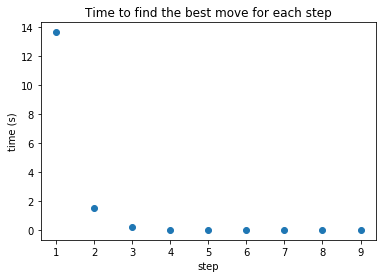

In average it took 15.34s to finish a game


In [15]:
# Uncomment to regenerate the data

#time_steps = np.array([play_min_max_min_max(False) for _ in range(10)])
#np.save('data/time_steps', time_steps)

time_steps = np.load('data/time_steps.npy')
mean_time_steps = np.mean(time_steps, axis=0)

mean_game = np.mean(np.sum(time_steps, axis=1))

plt.title('Time to find the best move for each step')
plt.xlabel('step')
plt.ylabel('time (s)')

plt.plot([i for i in range(1,10)], mean_time_steps, 'o')

# Change the image at the top

#plt.savefig('data/time_steps.png')

plt.show()

print('In average it took {:.2f}s to finish a game'.format(mean_game))

### I.2.d - Optimisation <a id="optimisation"></a>
L'étape suivante est donc de réduire le temps de recherche et pour cela le principal obstacle est : 

*L'algorithme MinMax passe plusieurs fois par les même situation donc calcule plusieurs fois les même branches.*

Pour optimiser on peut passer par de la programmation dynamique en mémoïsant les situations. 

Si l'ordinateur joue en premier, MinMax lui fait tester toutes les combinaisons de parties. J'ai donc décidé de précalculer toutes les situations possibles pour réduire la recherche de meilleur déplacement à une simple recherche dans une table. 

**Principe :**
Je génère toutes les combinaisons de situation possible : produit cartésien de 9 ensembles de 3 éléments.
Je garde que les situations possibles : 
- la différence de 'X' et de 'O' est au maximum de 1 
- il y a au maximum un seul joueur gagnant

In [16]:
def generate_all_boards():
    '''
    To generate all possible board combinations
    
    (No more than a difference of 1 between 'X' and 'O'
     And no more than one winner)
    '''
    
    players = ['X', 'O', ' ']
    all_comb = itertools.product(players, repeat = 9)
    all_comb = [np.resize(np.array(comb), (3,3)) for comb in all_comb]

    all_boards = []
    for board in all_comb:
        unique, counts = np.unique(board, return_counts=True)
        dict_ = dict(zip(unique, counts)) 

        if abs(dict_.get('O', 0) - dict_.get('X', 0)) < 2:
            all_boards += [board]

    boards = []
    for board in all_boards:

        winners = []

        # check for three identical symbols verticaly or horizontaly
        for i in range(3):
            if board[i,0] != ' ' and len(set(board[i,:])) == 1:
                winners += [board[i,0]]
            if board[0,i] != ' ' and len(set(board[:,i])) == 1: 
                winners += [board[0,i]]

        # check diagonaly
        if board[0,0] != ' ' and board[0,0] == board[1,1] == board[2,2]:
            winners += [board[1,1]]   
        if board[0,2] != ' ' and board[0,2] == board[1,1] == board[2,0]:
            winners += [board[1,1]]

        # If there is two winner the situation is impossible
        if len(set(winners)) < 2: 
            boards += [board]
    
    return(boards)       

In [17]:
def generate_all_best_moves(all_boards):
    '''
    generate all the best moves for every situation
    
    Retruns a list of dict : all_best_move[<board>] = {<player>: <best_move>}
    '''
    
    all_best_moves = []
    for i, board in enumerate(all_boards):

        # To know the time needed 
        print("\rBoard {}/{}.".format(i+1, len(all_boards)), end="")
        sys.stdout.flush()

        # Check if it is a playable situation 
        if state_board(board)[0] == "Not Done":
            # Detects which player can play
            unique, counts = np.unique(board, return_counts=True)
            dict_ = dict(zip(unique, counts)) 

            if dict_.get('O', 0) > dict_.get('X', 0):
                pos_players = [0]
            elif dict_.get('X', 0) > dict_.get('O', 0):
                pos_players = [1]
            else:
                pos_player = [0, 1]

            best_moves = {}
            for player in pos_player:
                best_moves[player] = best_play(board, player) 

            all_best_moves += [best_moves]
        else:
            all_best_moves += [{}]
    
    return(all_best_moves)

In [18]:
# Uncomment to regenerate all possible boards

#all_boards = generate_all_boards()
#np.save('data/all_boards', all_boards)

# Loads all possible boards

all_boards = np.load('data/all_boards.npy')

# Uncomment to regenerate all the best moves 

#all_best_moves = generate_all_best_moves(all_boards)
#np.save('data/all_best_moves', all_best_moves)

# Loads all the best moves

all_best_moves = np.load('data/all_best_moves.npy', allow_pickle=True)

In [19]:
def find_indice(all_boards, board):
    '''
    Find the indice of the board in all boards
    '''
    
    for i, x in enumerate(all_boards):
        if np.array_equal(board, x):
            return(i)
    return(None)

In [20]:
class minmax_test(unittest.TestCase):
    '''
    Test case for the minmax best move
    '''
    
    def test_move(self):
        '''
        Test if the program is capable of doing the best move
        '''
        
        players = ['X', 'O']
        
        state1 = np.array([['O', 'X', 'O'],
                           ['X', 'X', 'O'],
                           ['O', ' ', 'X']])
        state2 = np.array([['O', 'X', 'O'],
                           ['X', ' ', ' '],
                           ['O', ' ', 'X']])
        
        
        
        self.assertEqual(best_play(state1, 0), 8)
        self.assertEqual(best_play(state2, 1), 5)
        self.assertEqual(best_play(state2, 0), 5)
    
    def test_all_board(self):
        '''
        Test if only the correct boards are kept
        '''
        
        state1 = np.array([['O', 'X', 'O'],
                           ['X', ' ', ' '],
                           ['O', ' ', 'X']])
        state2 = np.array([['O', 'X', 'O'],
                           ['X', 'X', 'O'],
                           ['X', ' ', 'X']])
        state3 = np.array([['O', 'X', 'O'],
                           ['O', 'X', ' '],
                           ['O', 'X', 'X']])
        
        self.assertIsNotNone(find_indice(all_boards, state1))
        self.assertIsNone(find_indice(all_boards, state2))
        self.assertIsNone(find_indice(all_boards, state3))
        
    def test_move_precalcul(self):
        '''
        Test if the precalcul program gives the same as minmax
        '''
        
        players = ['X', 'O']
        
        state1 = np.array([['O', 'X', 'O'],
                           [' ', 'X', 'O'],
                           ['O', ' ', 'X']])
        state2 = np.array([['O', 'X', 'O'],
                           ['X', ' ', ' '],
                           ['O', 'X', 'X']])
        
        ind1 = find_indice(all_boards, state1)
        ind2 = find_indice(all_boards, state2)
        
        self.assertEqual(all_best_moves[ind1][0], best_play(state1, 0))
        self.assertEqual(all_best_moves[ind2][1], best_play(state2, 1))
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_all_board (__main__.minmax_test) ... ok
test_move (__main__.minmax_test) ... ok
test_move_precalcul (__main__.minmax_test) ... ok
test_win (__main__.moripion_test) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.162s

OK


In [21]:
def play_human_min_max_quick():
    '''
    A game of Tic-tac-toe for a human against the minmax
    
    Optimized
    '''
    
    # Initalisation
    board = np.full((3,3), ' ')
    players = ['X', 'O']

    state = "Not Done"
    player = 0
    AI = 1
    
    while state == "Not Done":
        
        # player turn
        print_board(board)
        play_move(board, players[player])
        state, winner = state_board(board)
       
        if state != "Not Done":
            break
            
        # IA turn
        indice = find_indice(all_boards, board)
        move(board, players[AI], all_best_moves[indice][AI])
        state, winner = state_board(board)
        
    print_board(board)
    
    if state == "Done":
        print(f"{winner} have won")
    else:
        print("It a draw")

In [22]:
#play_human_min_max_quick()

In [23]:
def play_min_max_min_max_quick(verb=True):
    '''
    A game of Tic-tac-toe for the minmax against the minmax
    
    Optimized
    ''' 
    
    # Initalisation
    board = np.full((3,3), ' ')
    players = ['X', 'O']
    player = 0

    state = "Not Done"
    
    time_steps = []
    
    while state == "Not Done":
        
        t1 = time()
        # AI turn
        indice = find_indice(all_boards, board)
        move(board, players[player], all_best_moves[indice][player])
        state, winner = state_board(board)
        t2 = time()
        
        time_steps += [t2-t1]
        
        # Change player 
        player = (player + 1) % 2
        
        if verb: 
            print_board(board)
            print('It took {:.2f}s to find the move'.format(time_steps[-1]))
       
        if state != "Not Done":
            break
        
    if verb:
        if state == "Done":
            print(f"{winner} have won")
        else:
            print("It a draw")
    
    return(time_steps)

#### I.2.d Optimisation (Suite)

Ci-dessous il y a les deux résultats de l'optimisation :
- le graphique du temps par étapes
- le temps (en commentaire rouge) pour précalculer les déplacements optimaux

Le temps de génération de tous les états est long : 3min. Mais une fois qu'il a été calculé accéder au déplacement optimal étant donné une situation est nettement plus rapide : 10 ms. 

Il est intéressant de voir qu'il y a toujours un temps plus long pour les situations initiales par rapport aux suivantes. Précédemment cela venait de la différence de profondeur de l'arbre de recherche mais ici c'est une toute autre raison : la génération de la table.

En effet, lorsqu'on a généré la table on a fait le produit cartésien de l'ensemble ['X','O',' '] cela peut sembler anodin mais cela signifie que les premiers états générés sont les états remplis de 'X' puis remplis de 'O' pour finalement être remplis de ' '. Les premiers états étant principalement vide il faut 'traverser' toute la table pour trouver le bon déplacement prenant ainsi plus de temps.

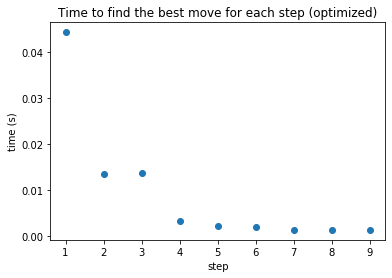

In average it took 0.08s to finish a game


In [24]:
# Uncomment to regenerate the data

#time_steps_opti = np.array([play_min_max_min_max_quick(False) \
#                                                    for _ in range(10)])
#np.save('data/time_steps_opti', time_steps_opti)

time_steps_opti = np.load('data/time_steps_opti.npy')
mean_time_steps_opti = np.mean(time_steps_opti, axis=0)

mean_game_opti = np.mean(np.sum(time_steps_opti, axis=1))

plt.title('Time to find the best move for each step (optimized)')
plt.xlabel('step')
plt.ylabel('time (s)')

plt.plot([i for i in range(1,10)], mean_time_steps_opti, 'o')

# Change the image at the top
#plt.savefig('data/time_steps_opti.png')

plt.show()

print('In average it took {:.2f}s to finish a game'.format(mean_game_opti))

In [25]:
%%timeit -n 1 -r 1

#all_boards = generate_all_boards()
#all_best_moves = generate_all_best_moves(all_boards)

'''
3min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
'''

702 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### I.2.e - Conclusion <a id="conclusion"></a>

En conclusion de cette partie, on voit que l'on obtient un algorithme performant en combinant la méthode de MinMax et le précalcul.

Cet algorithme va donc être utilisé pour entrainer efficacement les prochains algorithmes.

## I.3 - Apprentissage par renforcement <a id="apprentissage-par-renforcement"></a>

Tous les jeux ne sont pas aussi propices pour une méthode MinMax ou plus généralement une méthode exhaustive. On le voit déjà pour le morpion où la recherche dans l'arbre "explose" lorsque la profondeur augmente. 

Le but de l'apprentissage par renforcement est d'approximer la recherche exhaustive par un grand nombre d'expériences en mettant à jour les valeurs des différentes situations au fur et à mesure.

### I.3.a - Principe général <a id="principe-general"></a>

L'apprentissage par renforcement repose sur deux principes :
- un score numérique est donné à chaque situation possible
- l'agent peut choisir d'explorer ou de suivre la décision optimale




A chaque passage sur un état on modifie la valeur que l'on avait de celui-ci vers la valeur que l'on pense qu'il doit être.

Avec :
\begin{equation}
\left\{
\begin{array}{ll}
v &: \textrm{la fonction de valeur d'état} \\
s_t &: \textrm{l'état à l'instant } t \\
\alpha &: \textrm{coefficient d'apprentissage} \\
\end{array}
\right. \\
\end{equation}
$$ v(s_t) = v(s_t) + \alpha (v(s_{t+1}) - v(s_t)) $$

A noté que je prendrai l'agent comme 'X' arbitrairement : il sera le premier à jouer.

In [26]:
def init_value_board(value_boards):
    '''
    Initialise the value of the state that we know the value
    
    If 'X' win the value is 1, if it loose it is -1, else it is 0
    '''
    
    for i, board in enumerate(all_boards):
        _, winner = state_board(board)
        if winner == 'X':
            value_boards[i] = 1
        elif winner == 'O':
            value_boards[i] = -1

def update_state_values_X(value_boards, state, next_state, alpha, verb=True):
    '''
    Update the state value toward the real value using the formula above
    '''
    
    value = value_boards[state]
    next_value = value_boards[next_state]
        
    value_boards[state] += alpha*(next_value - value)
    if verb: print(f'{state} : {value} --> {next_value}')

On choisit le prochain déplacement en suivant la règle suivante : 

Avec une probabilité $\epsilon$ on choisit aléatoirement un déplacement c'est **l'exploration**

Sinon on regarde tous les déplacements et on prend le déplacement qui donne la situation avec le meilleur score c'est **l'exploitation**


In [27]:
def best_move_RL(value_boards, board, epsilon, verb=True):
    '''
    Gives the next move using the method above 
    '''
    
    values = []
    empty_cells = [num for num in range(1,10) if board[num2pos(num)] == ' ']
    
    for empty_cell in empty_cells:
        new_board = np.copy(board)
        move(new_board, 'X', empty_cell)
        
        values += [value_boards[find_indice(all_boards, new_board)]]
    
    if verb: print(f'Possible moves : {empty_cells}')
    if verb: print(f'Move values : {values}')
    
    values = np.array(values)
    
    if np.random.rand() < epsilon:   # Exploration
        best_move = np.random.choice(empty_cells)
        if verb: print(f'Agent decides to explore: {best_move}')
    else:    # Exploitation
        best_moves_ind = [i for i in range(len(values)) \
                                          if values[i] == values.max()]
        best_move = empty_cells[np.random.choice(best_moves_ind)]
        if verb: print(f'Agent decides to exploit: {best_move}')
    
    return(best_move)

### I.3.b - Implémentation du jeu <a id="implementation-du-jeu"></a>

In [28]:
def play_RL_min_max(value_boards, epsilon=0.2, alpha=0.2, verb=True, learn=True):
    '''
    A game of Tic-tac-toe for a RL against the minmax
    '''
    
    players = ['X', 'O']
    
    board = np.full((3,3), ' ')
    state = "Not Done"
    
    while state == "Not Done":
        
        # AI_RL turn
        move(board, players[0], best_move_RL(value_boards, board, epsilon, verb))
        state, winner = state_board(board)
        
        curr_state_id = find_indice(all_boards, board)
        
        if verb: print_board(board)
                
        if state != "Not Done":
            break

        # AI_MinMax turn
        indice = find_indice(all_boards, board)
        move(board, players[1], all_best_moves[indice][1])
        state, winner = state_board(board)

        if verb: print_board(board)

        next_state_id = find_indice(all_boards, board)
            
        if learn: update_state_values_X(value_boards, curr_state_id, next_state_id, alpha, verb)
    
    if verb:        
        if state == "Done":
            print(f"{winner} have won")
        else:
            print("It a draw")
    
    return(winner, board)

In [29]:
value_boards = np.zeros(len(all_boards))
init_value_board(value_boards)
tmp = play_RL_min_max(value_boards)

Possible moves : [1, 2, 3, 4, 5, 6, 7, 8, 9]
Move values : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Agent decides to explore: 4
┌───┬───┬───┐
│   │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
8458 : 0.0 --> 0.0
Possible moves : [2, 3, 5, 6, 7, 8, 9]
Move values : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Agent decides to explore: 8
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │ X │   │
└───┴───┴───┘
┌───┬───┬───┐
│ O │   │ O │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │ X │   │
└───┴───┴───┘
5393 : 0.0 --> 0.0
Possible moves : [2, 5, 6, 7, 9]
Move values : [0.0, 0.0, 0.0, 0.0, 0.0]
Agent decides to exploit: 2
┌───┬───┬───┐
│ O │ X │ O │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │ X │   │
└───┴───┴───┘
┌───┬───┬───┐
│ O │ X │ O │
├───┼───┼───┤
│ X │ O │   │
├───┼───┼───┤
│   │ X │   │
└───┴───┴───┘
3281 : 0.0 --> 0.0
Poss

On remarque que pour sa première partie l'agent ne peut pas choisir de "meilleure" solution car tous les états sont évalués de la même manière : 0

**Il n'a rien appris**

On va donc le faire jouer un grand nombre de fois contre l'algorithme MinMax pour apprendre (d'où l'optimisation nécessaire).

In [30]:
def train_RL(value_boards, nb_turn, train_fun, epsilon=0.2, learn=True):
    '''
    Make the agent (train_fun) play a lot against the MinMax algorithm
    
    learn: turn on or off the learning of the algorithm
            usefull to test how good is a AI 
    
    Retruns:
        value_boards
        list_winner_id : [{-1,1,0} for each play]
        list_winner : [{'O','X',None}, board for each play]
    '''
    
    list_winner = []
    
    for i in range(nb_turn):
        # To know the time needed 
        print("\rPlay {}/{}.".format(i+1, nb_turn), end="")
        sys.stdout.flush()

        list_winner += [train_fun(value_boards,epsilon=epsilon, learn=learn, verb=False)]
    
    list_winner_ind = []
    for w in list_winner:
        if w[0] == 'O':
            list_winner_ind += [-1]
        if w[0] == None:
            list_winner_ind += [0]
        if w[0] == 'X':
            list_winner_ind += [1]
    
    return(list_winner_ind, list_winner)

### I.3.c - Apprentissage <a id="apprentissage"></a>

Le principe est le suivant : 
- On fait apprendre l'algorithme sur 100 tours contre le MinMax
- On sauvegarde la table de valeur

On répète cela 10 fois donc l'algorithme aura jouer 1000 parties.

In [31]:
# Uncomment to regenerate data

#value_boards_RL = np.zeros(len(all_boards))
#init_value_board(value_boards_RL)

#value_boards_RL_save = [np.copy(value_boards_RL)]

#for i in range(10):
#    train_RL(value_boards_RL, 100, play_RL_min_max)
#    value_boards_RL_save += [np.copy(value_boards_RL)]

#np.save('data/value_boards_RL_save', value_boards_RL_save)

value_boards_RL_save = np.load('data/value_boards_RL_save.npy', allow_pickle=True)

'''
17min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
'''

'\n17min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)\n'

### I.3.d - Résultats <a id="resultats-2"></a>

On voit que pour jouer 1000 parties il faut un peu plus de 17 minutes ce qui est long. Pour voir si l'algorithme a "appris", on va, pour chaque table de valeur, faire jouer l'algorithme en l'empèchant d'apprendre.

On retient ensuite qui a gagné : 
- 0 si égalité
- 1 s'il gagne
- -1 s'il perd

Comme MinMax ne perd jamais, il n'y a que des 0 et des -1. Faire la moyenne des points permet de savoir comment joue l'algorithme.
- moyenne à -1 : il ne fait que perdre
- moyenne à 0 : il n'y a que des égalités

In [32]:
#results = []

#for value_boards in value_boards_RL_save:
#    results += [train_RL(value_boards, 50, play_RL_min_max, 0, False)[0]]

#np.save('data/results_RL', all_results)

results = np.load('data/results_RL.npy')

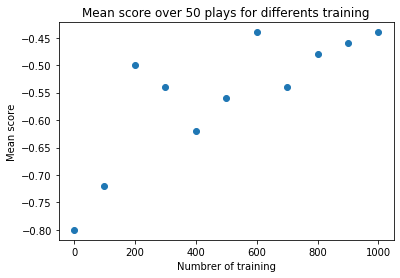

In [33]:
mean_score = [np.mean(x) for x in results]

plt.title('Mean score over 50 plays for differents training')
plt.xlabel('Numbrer of training')
plt.ylabel('Mean score')
plt.plot([i*100 for i in range(len(mean_score))], mean_score, 'o')

# Change the image at the top

#plt.savefig('data/mean_score.png')

plt.show()

On voit sur ce graphe qu'il y a bien un apprentissage car le score moyen à une bonne tendance à augmenter.

**L'algorithme apprend !**

Malheurseument l'apprentissage est très lent : 17 minutes pour aller de perdre 8 fois sur 10 à 4,5 fois sur 10.
En regardant de plus près le tableau de valeur on remarque qu'une grande partie des états ont un score à zéro. Cela vient du la façon dont on met à jour la table. 

Les changements ne se propagent que d'un état à un autre.

Autrement dit, lorsqu'on tombe sur une situation qui nous fait perdre on ne modifie le score que de l'état précédant. La propagation de score n'est pas optimale, on peut penser que tous les états qui ont précédé la défaite devrait être mis à jour.

### I.3.e - Apprentissage Monte-Carlo <a id="apprentissage-monte-carlo"></a>

L'algorithme suivant change donc la mise à jour de la table de valeur.
Cette fois ci, on fait une partie entièrement sans mettre à jour à chaque tour. On garde en mémoire les états parcourus dans une liste que l'on nomme : **épisode**

Ensuite à la fin de l'épisode on reprend les états un par un et on applique la formule suivante :

En posant : 
- $\alpha$ : la vitesse d'apprentissage
- $v(S_t)$ : la fonction de valeur à l'état $S$ à l'instant $t$ 
- $G_t$ : la somme des gains de $t$ jusqu'à la fin de l'épisode
- $\gamma$ : le facteur de propagation


$$ G_t = v(S_{t+1}) + \gamma v(S_{t+2}) + \gamma^2 v(S_{t+3}) + \dots $$
$$ v(S_t) = v(S_t) + \alpha (G_t - v(S_t)) $$

In [34]:
def update_state_values_X_MC(value_boards, episode, alpha, verb=True):
    '''
    Update the state value toward the real value using the Mont-Carlo forumla
    '''
    
    gamma = 0.5
    for i, state in enumerate(episode[:-1]):
        rewards = [gamma**j * value_boards[s] for j, s in enumerate(episode[i+1:])]

        value = value_boards[state]
        value_boards[state] += alpha*(sum(rewards) - value)
        if verb: print(f'{state} : {value} --> {sum(rewards)}')

In [35]:
def play_RL_min_max_MC(value_boards, epsilon=0.2, alpha=0.2, verb=True, learn=True):
    '''
    A game of Tic-tac-toe for a RL against the minmax with Monte-Carlo updates
    '''
        
    players = ['X', 'O']
    
    board = np.full((3,3), ' ')
    state = "Not Done"
    
    episode = []
    
    while state == "Not Done":
        
        # AI_RL turn
        move(board, players[0], best_move_RL(value_boards, board, epsilon, verb))
        state, winner = state_board(board)
        
        episode += [find_indice(all_boards, board)]
        
        if verb: print_board(board)
                
        if state != "Not Done":
            break

        # AI_MinMax
        indice = find_indice(all_boards, board)
        move(board, players[1], all_best_moves[indice][1])
        state, winner = state_board(board)
                    
        if verb: print_board(board)
    
    episode += [find_indice(all_boards, board)]    
    
    if learn: update_state_values_X_MC(value_boards, episode, alpha, verb)
    
    alpha *= 0.99
    
    if verb:        
        if state == "Done":
            print(f"{winner} have won")
        else:
            print("It a draw")
    
    return(winner, board)

In [36]:
value_boards_RL_MC = np.zeros(len(all_boards))
init_value_board(value_boards_RL_MC)
play_RL_min_max_MC(value_boards_RL_MC)

Possible moves : [1, 2, 3, 4, 5, 6, 7, 8, 9]
Move values : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Agent decides to explore: 4
┌───┬───┬───┐
│   │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
Possible moves : [2, 3, 5, 6, 7, 8, 9]
Move values : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Agent decides to exploit: 6
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │   │ X │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │ O │ X │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
Possible moves : [2, 3, 7, 8, 9]
Move values : [0.0, 0.0, 0.0, 0.0, 0.0]
Agent decides to exploit: 9
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │ O │ X │
├───┼───┼───┤
│   │   │ X │
└───┴───┴───┘
┌───┬───┬───┐
│ O │   │ O │
├───┼───┼───┤
│ X │ O │ X │
├───┼───┼───┤
│   │   │ X │
└───┴───┴───┘
Possible moves : [2, 7, 8]
Move values : [0.0, 0.0, 0.0]
Agen

('O',
 array([['O', 'X', 'O'],
        ['X', 'O', 'X'],
        ['O', ' ', 'X']], dtype='<U1'))

Le principe est le suivant : 
- On fait apprendre l'algorithme sur 5 tours contre le MinMax
- On sauvegarde la table de valeur

On répète cela 30 fois donc l'algorithme aura jouer 150 parties.


In [37]:
# Uncomment to regenerate data

#value_boards_RL_MC = np.zeros(len(all_boards))
#init_value_board(value_boards_RL_MC)

#value_boards_RL_MC_save = [np.copy(value_boards_RL_MC)]

#for i in range(30):
#   train_RL(value_boards_RL_MC, 5, play_RL_min_max_MC)
#   value_boards_RL_MC_save += [np.copy(value_boards_RL_MC)]

#np.save('data/value_boards_RL_MC_save', value_boards_RL_MC_save)

value_boards_RL_MC_save = np.load('data/value_boards_RL_MC_save.npy', allow_pickle=True)

'''
5min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
'''

'\n5min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)\n'

### I.3.f - Résultats Monte-Carlo <a id="resultats-monte-carlo"></a>

On voit que pour jouer 150 parties, il faut un peu plus de 5 minutes, ce qui est bien plus court. Pour voir si l'algorithme a de nouveau "appris" on va utiliser le même principe que précédemment, pour chaque table de valeur, faire jouer l'algorithme en l'empêchant d'apprendre.

On retient ensuite qui a gagné : 
- 0 si égalité
- 1 s'il gagne
- -1 s'il perd

Comme MinMax ne perd jamais, il n'y a que des 0 et des -1. Faire la moyenne des points permet de savoir comment joue l'algorithme.
- moyenne à -1 : il ne fait que perdre
- moyenne à 0 : il n'y a que des égalités

In [38]:
# Uncomment to regenerate the data

#results_MC = []

#for i, value_boards in enumerate(value_boards_RL_MC_save):
#    results_MC += [train_RL(value_boards, 30, play_RL_min_max, 0, False)[0]]
    
#np.save('data/results_MC', results_MC)

results_MC = np.load('data/results_MC.npy', allow_pickle=True)

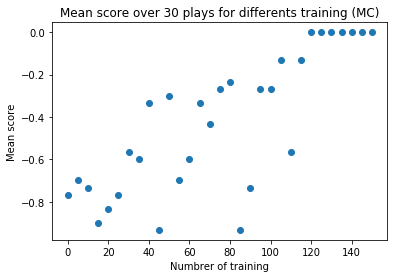

In [39]:
mean_score = [np.mean(x) for x in results_MC]

plt.title('Mean score over 30 plays for differents training (MC)')
plt.xlabel('Numbrer of training')
plt.ylabel('Mean score')
plt.plot([i*5 for i in range(len(mean_score))], mean_score, 'o')

# Change the image at the top

#plt.savefig('mean_score_MC.png')

plt.show()

On observe une nette amélioration. Là où il fallait 1000 parties pour arriver à 4,5 pertes sur 10, il n'en faut plus que 50 !

**Monte-Carlo améliore significativement l'apprentissage**

On peut toutefois soulever le fait que l'apprentissage est plus chaotique, c'est un des problèmes de la méthode de Monte-Carlo. En échange de cette augmentation de variance on peut entrainer l'algorithme jusqu'à la perfection et atteindre rapidement une moyenne de 0.

On arrive à des résultats aussi bons qu'avec une méthode de MinMax mais la vitesse de convergence dépend grandement de la méthode de mise à jour de la table des valeurs.

## I.4 - Conclusion <a id="conclusion-2"></a>

Le morpion est un jeu simple avec des règles précises et un environnement fixe. Il est donc très approprié pour une première implémentation d'algorithme de machine learning.

L'apprentissage par renforcement n'est en revanche pas très adapté dans le cas du Morpion car des algorithmes comme MinMax sont bien plus efficaces et ne demandent pas d'entraînement (sauf si on compte le précalcul comme tel). L'intérêt est donc limité ici.

Il faut bien voir que l'apprentissage par renforcement est bien plus versatile et ne demande pas autant de conditions que le MinMax pour être appliqué, c'est pourquoi la prochaine étape est d'appliquer ce que l'on a appris sur le Morpion à un jeu plus complexe : **Snake** 

# II - Snake <a id='snake'></a>

Le but de cette partie est de programmer un jeu snake qui utilisera des principes d'apprentissage par renforcement plus complexe pour crée un bot

## II.0 - Modules, Constantes et Autre <a id="modules"></a>

In [40]:
import operator
import math

In [41]:
CSTE_N = 10
CSTE_M = 10

In [42]:
import matplotlib.pyplot as plt
from matplotlib import animation

In [43]:
def annimationPlt(plateau, pos_j_init, list_pos_j, inter=50):
    fig, ax = plt.subplots()
    
    plt.rc('animation', html='html5')
    
    plt.set_cmap('gray')
    plt.axis([0, CSTE_M, 0, CSTE_N])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

    list_pos_j = [pos_j_init] + list_pos_j
    
    def init():
        return()

    def anni(i):

        [p.remove() for p in reversed(ax.patches)]

        (x,y) = plateau.pos_f
        box = plt.Rectangle([y,x], 1, 1, color="green", fill=True)
        ax.add_patch(box)

        (x,y) = plateau.pos_o
        box = plt.Rectangle([y,x], 1, 1, color="red", fill=True)
        ax.add_patch(box)

        (x,y) = list_pos_j[i]
        box = plt.Rectangle([y,x], 1, 1, color="silver", fill=True)
        ax.add_patch(box)

        return()

    return(animation.FuncAnimation(fig, anni, init_func=init,
                               frames=len(list_pos_j), interval=inter, blit=True))

In [44]:
def afficherPlt(plateau, pos_j):
    fig, ax = plt.subplots()
    
    
    plt.set_cmap('gray')
    plt.axis([0, CSTE_M, 0, CSTE_N])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

    
    
    (x,y) = plateau.pos_f
    box = plt.Rectangle([y,x], 1, 1, color="green", fill=True)
    ax.add_patch(box)

    (x,y) = plateau.pos_o
    box = plt.Rectangle([y,x], 1, 1, color="red", fill=True)
    ax.add_patch(box)

    (x,y) = pos_j
    box = plt.Rectangle([y,x], 1, 1, color="silver", fill=True)
    ax.add_patch(box)

    #plt.savefig('data/plt.png', bbox_inches='tight')
    plt.show()

In [45]:
from ipywidgets import Button, Layout, HBox, VBox

In [46]:
def selection_plateau_gui():

    items = [Button(layout=Layout(width='20px', height='20px')) for i in range(100)]
    rows = [VBox([items[i*10 + j] for j in range(10)]) for i in range(10)]

    restant = {'red': True,
                'lightgreen': True,
                'lightgray': True,
                'white': True}

    def on_button_clicked(b):

        for k in restant.keys():
            if restant[k]:
                if not(b.style.button_color == 'white'):
                    restant[b.style.button_color] = True

                b.style.button_color = k
                if not(k == 'white'):
                    restant[k] = False

                break

    but = Button()
    but.style.button_color = 'lightgreen'
    but.on_click(on_button_clicked)

    for b in items:
        b.style.button_color = 'white'
        b.on_click(on_button_clicked)

    return(items, HBox([rows[i] for i in range(10)], layout=Layout(width='240px', border='solid 1px')))


In [47]:
def get_pos_gui(items):
    pos_j, pos_f, pos_o = (-1,-1), (-1,-1), (-1,-1)
    
    for i, b in enumerate(items):
        if b.style.button_color == 'lightgray':
            pos_j = (i%10, i//10)
        elif b.style.button_color == 'lightgreen':
            pos_f = (i%10, i//10)
        elif b.style.button_color == 'red':
            pos_o = (i%10, i//10)
            
    return(pos_j, pos_f, pos_o)

## II.1 - Moteur du jeu <a id="moteur-du-jeu-snake"></a>

### II.1.a - Principe <a id="principe-snake"></a>

Avant de s'attaquer au jeu complet Snake on commence par programmer une forme simplifiée de snake avec un serpent de taille 1, un fruit, un obstacle.
On cherche a avoir le serpent qui se déplace vers le fruit sans toucher l'obstacle.

## II.1.b - Environnement <a id="environnement-snake"></a>

Le plateau est un tableau de zéros de taille NxM, 

On génère aléatoirement la position de l'obstacle et du fruit.

In [48]:
class Plateau():
    def __init__(self, N=CSTE_N, M=CSTE_M):
        self.N = N
        self.M = M
        
        self.tbl = np.zeros((N,M))
                
        self.reset()
        
    def posAlea(self):
        x,y = np.random.randint(0, self.N), np.random.randint(0, self.M)
        while (x,y) in [self.pos_f, self.pos_o]:
            x,y = np.random.randint(0, self.N), np.random.randint(0, self.M)
           
        return((x,y))
    
    def reset(self):
        self.pos_f, self.pos_o = (-1, -1), (-1, -1) 
        
        self.pos_f = self.posAlea()
        self.pos_o = self.posAlea()
    
    def afficher(self, pos_j=(-1,-1)):

        s = '─'*(self.M+2) + '\n'
        
        for i in range(self.N):
            s += '|'
            for j in range(self.M):
                if (i,j) == pos_j:
                    s += '@'
                elif (i,j) == self.pos_f:
                    s += '€'
                elif (i,j) == self.pos_o:
                    s += '■'
                else:
                    s += ' '
            s += '|\n' 
            
        s += '─'*(self.M+2) + '\n'
        
        print(s)

In [49]:
p = Plateau()

In [50]:
p.afficher()

────────────
|     €    |
|          |
|          |
|          |
|          |
|          |
|          |
|      ■   |
|          |
|          |
────────────



## II.1.c - Déplacements du joueur et score <a id="deplacement-du-joueur"></a>

On créé les quatres déplacements possibles du joueurs :
- $0$ : haut
- $1$ : droite
- $2$ : bas
- $3$ : gauche

Le gain est de :
- $-1$ pour les cases vides
- $0$ pour le fruit
- $-30$ pour l'obstacle

L'état après déplacement est :
- position du joueur

On renvoit également l'état de la partie : "terminée" ou non

In [51]:
class Plateau():
    def __init__(self, N=CSTE_N, M=CSTE_M):
        self.N = N
        self.M = M
       
        self.reset()
        
    def posAlea(self):
        x,y = np.random.randint(0, self.N), np.random.randint(0, self.M)
        while (x,y) in [self.pos_f, self.pos_o]:
            x,y = np.random.randint(0, self.N), np.random.randint(0, self.M)
           
        return((x,y))
    
    def reset(self):
        self.pos_f, self.pos_o = (-1, -1), (-1, -1) 
        
        self.pos_f = self.posAlea()
        self.pos_o = self.posAlea()
    
    def afficher(self, pos_j=(-1,-1)):

        s = '─'*(self.N+2) + '\n'
        
        for i in range(self.N):
            s += '|'
            for j in range(self.M):
                if (i,j) == pos_j:
                    s += '@'
                elif (i,j) == self.pos_f:
                    s += '€'
                elif (i,j) == self.pos_o:
                    s += '■'
                else:
                    s += ' '
            s += '|\n' 
            
        s += '─'*(self.N+2) + '\n'
        
        print(s)
    
    # ******************************************************* # Rajout
    def deplacement(self, pos_j, direction):
        pos = {0: (-1, 0),   # Haut
               1: (0, 1),    # Droite
               2: (1, 0),    # Bas
               3: (0, -1)}   # Gauche
        
        next_pos = tuple(map(operator.add, pos_j, pos[direction])) # (a,b) + (c,d) = (a+c, b+d)

        if not(-1 in next_pos or next_pos[0] == self.N or next_pos[1] == self.M):
            pos_j = next_pos
       
        gain = -1 + int(pos_j == self.pos_f) + int(pos_j == self.pos_o)*-29
        
        return(pos_j, gain, pos_j==self.pos_f)
    # ******************************************************* #

In [52]:
p = Plateau()
p.pos_o = (1,0)
p.pos_f = (2,0)

In [53]:
p.afficher((0,0))
print("Déplacement à gauche : " + str(p.deplacement((0,0), 3)))
print("Déplacement en bas : " + str(p.deplacement((0,0), 2)))

────────────
|@         |
|■         |
|€         |
|          |
|          |
|          |
|          |
|          |
|          |
|          |
────────────

Déplacement à gauche : ((0, 0), -1, False)
Déplacement en bas : ((1, 0), -30, False)


## II.2 - Apprentissage par renforcement <a id="apprentissage_par_renforcement_snake"></a>

Ce qu'il faut bien voir ici, c'est que la *stratégie* que l'on demande à notre algorithme de trouver n'est pas fixe par rapport au plateau. En effet, la position relative des trois objets est aléatoire au début de chaque partie.

On va donc, dans un premier temps, voir si prendre comme *vecteur de caractéristique* la distance entre le joueur et le fruit et le joueur et l'obstacle va être suffisant pour avoir une *stratégie* efficace.

$$X = \begin{pmatrix} d_{joueur-fruit} \\ d_{joueur-obstacle} \end{pmatrix}$$

### II.2.a - Fonctions utiles <a id="fonctions_utiles"></a>

#### Fonction distance

In [54]:
def dist(x, y):
    return(math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2))

#### Fonction valeurs d'états

Cette fonction donne la valeur d'un état (position) en fonction d'un vecteur de pondération des caractérisitique $w$:

- On calcule le vecteur de caractéristique : 
$$vct = \begin{pmatrix} d_{joueur-fruit} \\ d_{joueur-obstacle} \end{pmatrix}$$
- On calcule ensuite la valeur de cet état pondérée par $w$ :
$$valeur = vct_1 w_1 + vct_2 w_2$$

In [55]:
def vectCara(plateau, pos_j):
    pos_f = plateau.pos_f
    pos_o = plateau.pos_o
    
    dist_max = dist((0,0), (plateau.N, plateau.M))
    
    dist_f = dist(pos_j, pos_f)
    dist_o = dist(pos_j, pos_o)
    
    
    return(np.array([dist_f, dist_o]))

In [56]:
def Q(plateau, pos_j, w):
    
        valeur_etat = sum(np.multiply(vectCara(plateau, pos_j),w))
                    
        return(valeur_etat)

Pour bien comprendre on se place juste à coté du fruit et on prends une pondération (-1,0). 

Ce vecteur de pondération ne prends en compte que la distance du joueur au fruit.

In [57]:
plateau = Plateau()
plateau.pos_f = (2,1)
plateau.pos_o = (5,5)

In [58]:
plateau.afficher((0,1))

────────────
| @        |
|          |
| €        |
|          |
|          |
|     ■    |
|          |
|          |
|          |
|          |
────────────



In [59]:
valeur  = Q(plateau, (0,1), (-1,0))
print(f"La valeur de la case (0,1) avec la pondération (-1,0) est {valeur}")

La valeur de la case (0,1) avec la pondération (-1,0) est -2.0


On a bien une valeur proche de ce que l'on penserait si on ne prenait en compte que la distance au fruit

#### Stratégie

Cette fonction code la stratégie $\epsilon$-greedy.

Pour garder une part d'exploration on prends majoritairement l'action qui nous donne la valeur la plus grande. Parfois, on prend des actions aléatoirement. 

Mathématiquement : 
$$\pi(S,w) = \left \{ \begin{align*}
                            1 - \epsilon + \frac{\epsilon}{4} &\textrm{ si l'action est optimale} \\
                            \frac{\epsilon}{4} &\textrm{ sinon}
                         \end{align*} \right.$$


In [60]:
def strategie(plateau, etat, w, epsilon):
        """
        Stratégie epsilon greedy
        """
        prob = np.ones(4) * epsilon/4
        
        valeurs_voisins = np.zeros(4)
        
        for action in range(4):
            next_pos, _, _ = plateau.deplacement(etat, action)
            
            valeurs_voisins[action] = Q(plateau, next_pos, w)
        
        # On récuppère tous les indices des actions donc la valeur est maximal
        best_actions = [i for i in range(4) if valeurs_voisins[i] == valeurs_voisins.max()]

        best_action = np.random.choice(best_actions)
        
        prob[best_action] += 1 - epsilon
        
        return(prob)

In [61]:
strategie(plateau, (0,1), (-1,0), 0)

array([0., 0., 1., 0.])

On a bien que lorsqu'on est sur la case (0,1) la meilleur action (epsilon = 0) est d'aller en bas

#### Fonction génération d'épisode

Pour Monte-Carlo, on doit finir les épisodes. Cette fonction génère un épisode en suivant une stratégie.

In [62]:
def generationEpisode(plateau, w, epsilon, pos_j=plateau.posAlea(), nb_max = 5000):
    
    episode = []
    
    while True: # On joue jusqu'à ne plus pouvoir ou que c'est trop long

        # On réupère le vecteur de probabilité de l'état et on choisi une action en suivant ce vecteur
        prob = strategie(plateau, pos_j, w, epsilon)
        action = np.random.choice(np.arange(len(prob)), p=prob)
        
        next_pos, gain, done = plateau.deplacement(pos_j, action)
        episode.append((next_pos, action, gain, done))
        
        if done:
            break

        pos_j = next_pos
    
    return(episode)

Pour mieux comprendre on génère un épisode avec le vecteur de pondération (0,0) le joueur se deplacera donc aléatoirement.

In [63]:
%%capture

# On crée une planche aléatoire
plateau = Plateau()
pos_j_init = plateau.posAlea()

w = (0,0)
epsilon = 0.0  # On retire l'aléatoire dans le choix des décisions (greedy)

episode = generationEpisode(plateau, w, epsilon, pos_j=pos_j_init)
list_pos_j = [x[0] for x in episode]

annim = annimationPlt(plateau, pos_j_init, list_pos_j, inter=20)

# Change l'annimation en haut

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#annim.save('data/snake_rand.mp4', writer=writer)

In [64]:
annim

### II.2.b - Apprentissage Monte Carlo <a id="apprentissage-monte-carlo-snake"></a>

Il est maintenant l'heure d'apprendre !

Ici l'apprentissage se fait par la détermination de $w$.

**Formule Monte-Carlo avec approximation de fonction linéaire**

En posant : 
- $\alpha$ : la vitesse d'apprentissage
- $\hat{Q}(S, w)$ : la fonction de valeur à l'état $S$ à l'instant $t$ avec le vecteur de pondération $w$
- $G_t$ : la somme des gains de $t$ jusqu'à la fin de l'épisode
- $X(S_t)$ : le vecteur de caractérisitque de l'état $S$ à l'instant $t$
    
$$ \Delta w = \alpha (G_t - \hat{Q}(S, w)) X(S_t) $$

In [65]:
def mcControlEpsilonGreedy(plateau, nb_episodes, w=np.array([0., 0.]), alpha=0.001, gamma=1.0, epsilon=0.1):
    """
    Entrées :
        plateau : environnement d'apprentissage
        nb_episode : le nombre d'épisodes effectués
        w : vecteur de poids inital (np array)
        gamma : coefficient de remise ([0,1])
        epsilon : la probabilité de prendre une action aléatoire ([0,1])
    
    Sorties :
        w : le vecteur de pondération
    """
    
    for n in range(nb_episodes):
        # Pour savoir le temps que l'execution prends 
        if ((n+1) % 10) == 0:
            print(f"\rEpisode {n+1}/{nb_episodes}.", end="")   
        
        plateau.reset()
        pos_j = plateau.posAlea()
        
        episode = generationEpisode(plateau, w, epsilon, pos_j)
        
        for i, (pos_j, _, gain, done) in enumerate(episode):
            
            G_t = sum([gain for (_,_,gain,_) in episode[i:]])
            
            delta = G_t - Q(plateau, pos_j, w)
            
            vect = vectCara(plateau, pos_j)
            
            delta_w = alpha * delta * vect

            # Mise à jour de w
            w = [sum(x) for x in zip(w, delta_w)]
           
            if done:
                break
        
        # Test pour savoir si la pondération sur la distance du joueur au fruit est positive
        if w[0] > 0:
            print(f"ERROR : Le joueur cherche à s'éloigné du fruit !", end='')
            break
        
            
    return(w)
    

In [66]:
p = Plateau()
w_app = mcControlEpsilonGreedy(plateau, 100)
print(f'\nLe vecteur de pondération : {w_app}')

Episode 100/100.
Le vecteur de pondération : [-1.5455331523747013, 0.15720751932730317]


Il est interessant de comprendre pourquoi le code ci-dessus ne fonctionne pas.

Les épisodes ne terminent pas lorsqu'il y a une pondération positive sur la distance du joueur au fruit. En effet, si cela arrive le joueur tentera de s'éloigner du fruit et donc ne pourra pas terminer la partie.

La pondération positive peut provenir d'une situation où le joueur est sur l'obstacle et que le fruit est proche. La différence de point entre ce que le poids prédit et la réalité des points de pénalité de l'obstacle sera entièrement porté par la distance au fruit la rendant positive.

La conclusion est que **le vecteur de caractéristique n'est pas adapté pour une utilisation de Monte-Carlo.**

### II.2.c - Apprentissage Temporal Difference <a id="temporal-difference"></a>

Comme la méthode de Monte-Carlo ne fonctionnait pas à cause des gains sur le futur qui poussaient le vecteur de pondération dans une direction trop éloignée, on utilise une méthode avec une variance bien moindre : le *temporal difference*. Très grossièrement, on prend l'approximation de la valeur de la prochaine case plus le gain à la place de $G_t$.

**Formule Apprentissage $TD(0)$ avec approximation de fonction**

En posant : 
- $\hat{Q}(S, w)$ : la fonction de valeur à l'état $S$ à l'instant $t$ avec le vecteur de pondération $w$
- $target$ : La valeur que l'on cherche à approximer
- $S'$ : le prochain état
- $\delta$ : l'écart d'approximation
- $X(S_t)$ : le vecteur de caractérisitque de l'état $S$ à l'instant $t$
    
$$\begin{align}
target &= R_t + Q(S', w) \\
\delta &= target - Q(S, w) \\
\Delta w &= \alpha \delta X(S_t)
\end{align}$$

In [67]:
def tdControlEpsilonGreedy(plateau, nb_episodes, w=np.array([0.,0.]), alpha=0.001, gamma=1.0, epsilon=0.1):
    """
    Entrées :
        plateau : environnement d'apprentissage
        nb_episode : le nombre d'épisodes effectués
        w : vecteur de poids inital (np array)
        gamma : coefficient de remise ([0,1])
        epsilon : la probabilité de prendre une action aléatoire ([0,1])
    
    Sorties :
        w : le vecteur de pondération
    """
    
    for n in range(nb_episodes):
        # Pour savoir le temps que l'execution prends 
        if ((n+1) % 10) == 0:
            print(f"\rEpisode {n+1}/{nb_episodes}.", end="")
                
        plateau.reset()
        pos_j = plateau.posAlea()
        
        while True:
            # On réupère le vecteur de probabilité de l'état et on choisi une action en suivant ce vecteur
            prob = strategie(plateau, pos_j, w, epsilon)
            # TD(0)
            action = np.random.choice(np.arange(len(prob)), p=prob)
            
            next_pos, gain, done = plateau.deplacement(pos_j, action)
            
            # Formule d'apprentissage (TD(0))
            td_target = gain + gamma*Q(plateau, next_pos,w)
            delta = td_target - Q(plateau, pos_j,w) 
            
            vect = vectCara(plateau, pos_j)
            
            delta_w = alpha * delta * vect
           
            # Mise à jour de w
            w = [sum(x) for x in zip(w, delta_w)]
           
            if done:
                break
                
            pos_j = next_pos
            
        # Test pour savoir si la pondération sur la distance du joueur au fruit est positive
        if w[0] > 0:
            print(f"ERROR : Le joueur cherche à s'éloigné du fruit !")
            break

                    
    return(w)

In [68]:
p = Plateau()

w_list = [tdControlEpsilonGreedy(plateau, 5000) for i in range(1)]

print('\n' + '\n'.join([f'{w[0]}, {w[1]}' for w in w_list]))

w_app_2 = np.mean(w_list, axis=0)

Episode 5000/5000.
-1.6315897840132987, 1.3142064838437957


L'apprentissage a l'air de fonctionné plus régulièrement que Monte-Carlo. On voit que sur les 20 essais aucun n'a eu de pondération positive.

On peut également remarqué que les resultats ont l'air similaire on va donc prendre la moyenne de ces valeurs et tester l'apprentissage sur des cas particuliers.

In [69]:
# On crée un gui pour selectionner le placement des objets (pour un raison obscure ne fonctionne pas sur jupyter lab)
items, gui = selection_plateau_gui()
gui

# On créé donc notre plateau à la main dans le prochain bloc

In [81]:
%%capture

# On récupère les coordonnées du gui
#pos_j, pos_f, pos_o = get_pos_gui(items) (ne fonctionne pas sur jupyter lab)

# On crée des planches
p = Plateau()
p.pos_f = (0,0)
p.pos_o = (5,5)
pos_j_init = (8,8)

w = w_app_2
epsilon = 0.0  # On retire l'aléatoire dans le choix des décisions (greedy)

episode = generationEpisode(p, w, epsilon, pos_j=pos_j_init)
list_pos_j = [x[0] for x in episode]

# Change l'annimation en haut

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#annim.save('data/snake_strat.mp4', writer=writer)

annim = annimationPlt(p, pos_j_init, list_pos_j, inter=200)

ValueError: operands could not be broadcast together with shapes (4,) (2,) 

In [71]:
annim

En analysant les resultats lorsque l'on aligne les trois objets dans l'ordre : joueur, obstacle, fruit, on observe que si le fruit et le obstacle sont très éloigné le joueur gagnera plus de points en s'éloignant de l'obstacle quitte à alonger le parcours.

Ceci nous ammène à penser que **notre vecteur caractéristique ne permet pas de modélisé correctement la situation**.

Nous allons donc l'étoffer.

### I.3 - Meilleur vecteur caractéristique <a id="meilleur-vecteur"></a>

Nous allons poser un vecteur caractéristique dépendant de l'état mais également de l'action :

$$ X(S,a) = \begin{pmatrix} rapprochement\_fruit \\ rapprochement\_obstacle \\ d_{fruit} \\ d_{obstacle} \end{pmatrix} $$

Ce qui nous ammene à recoder les fonction Q et Stratégie

In [72]:
def vectCara(plateau, pos_j, action):
    next_pos,_,_ = plateau.deplacement(pos_j, action)
    
    pos_f = plateau.pos_f
    pos_o = plateau.pos_o
    
    dist_f_init = dist(pos_j, pos_f)
    dist_o_init = dist(pos_j, pos_o)
    
    dist_f_next = dist(next_pos, pos_f)
    dist_o_next = dist(next_pos, pos_o)
    
    return(np.array([dist_f_next - dist_f_init, dist_o_next - dist_o_init, dist_f_init, dist_o_init]))

In [73]:
def Q(plateau, pos_j, action, w):
    
        valeur_etat = sum(np.multiply(vectCara(plateau, pos_j, action),w))
                    
        return(valeur_etat)

In [74]:
def strategie(plateau, etat, w, epsilon):
        """
        Stratégie epsilon greedy
        """
        prob = np.ones(4) * epsilon/4
        
        valeurs_voisins = np.zeros(4)
        
        for action in range(4): 
            valeurs_voisins[action] = Q(plateau, pos_j, action, w)
        
        # On récuppère tous les indices des actions donc la valeur est maximal
        best_actions = [i for i in range(4) if valeurs_voisins[i] == valeurs_voisins.max()]

        best_action = np.random.choice(best_actions)
        
        prob[best_action] += 1 - epsilon
        
        return(prob)

On recode également la fonction d'apprentissage pour prendre en compte que l'état n'est plus que la position mais également l'action.
J'en profite également pour passer à l'apprentissage *Q_Learning*

$$target = R_t + \max_{a \in \mathcal{A}} Q(S_{t+1},a)$$

In [75]:
def qLearning(plateau, nb_episodes, w=np.array([0.,0.,0.,0.]), alpha=0.001, gamma=1.0, epsilon=0.1):
    """
    Entrées :
        plateau : environnement d'apprentissage
        nb_episode : le nombre d'épisodes effectués
        w : vecteur de poids inital (np array)
        gamma : coefficient de remise ([0,1])
        epsilon : la probabilité de prendre une action aléatoire ([0,1])
    
    Sorties :
        w : le vecteur de pondération
    """
    
    for n in range(nb_episodes):
        # Pour savoir le temps que l'execution prends 
        if ((n+1) % 10) == 0:
            print(f"\rEpisode {n+1}/{nb_episodes}.", end="")
                
        plateau.reset()
        pos_j = plateau.posAlea()
        
        while True:
            # On réupère le vecteur de probabilité de l'état et on choisi une action en suivant ce vecteur
            prob = strategie(plateau, pos_j, w, epsilon)
            action = np.random.choice(np.arange(len(prob)), p=prob)
            
            next_pos, gain, done = plateau.deplacement(pos_j, action)
            
            # Formule d'apprentissage (Q_learning)
            # On recherche la meilleur action possible:
            prob_best = strategie(plateau, next_pos, w, 0)
            action_best = np.random.choice(np.arange(len(prob_best)), p=prob_best)
            
            td_target = gain + gamma*Q(plateau, next_pos, action_best, w)
            delta = td_target - Q(plateau, pos_j, action, w) 
            
            vect = vectCara(plateau, pos_j, action)
            
            delta_w = alpha * delta * vect
           
            # Mise à jour de w
            w = [sum(x) for x in zip(w, delta_w)]
            #plateau.afficher(pos_j)
           
            if done:
                break
                
            pos_j = next_pos
                    
    return(w)

In [76]:
p = Plateau()
pos_j = p.posAlea()
w_app_3 = qLearning(plateau, 1, [0,0,0,0])
print(f'\nLe vecteur de pondération : {w_app_3}')


Le vecteur de pondération : [-0.003948338600483574, -0.004896510339383233, -0.28728941927474483, -0.24163508273693393]


In [77]:
%%capture

# On récupère les coordonnées du gui
#pos_j, pos_f, pos_o = get_pos_gui(items)

# On crée des planches
p = Plateau()
p.pos_f = (0,0)
p.pos_o = (5,5)
pos_j_init = (7,7)

w = w_app_3
epsilon = 1.0  # On retire l'aléatoire dans le choix des décisions (greedy)

episode = generationEpisode(p, w, epsilon, pos_j=pos_j_init)
list_pos_j = [x[0] for x in episode]

annim = annimationPlt(p, pos_j_init, list_pos_j, inter=20)

In [78]:
annim

In [79]:
print(w_app)

[-1.5455331523747013, 0.15720751932730317]
